In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [3]:
from pettingzoo.test import parallel_api_test
from solution.custom_gym import CustomGymEnviornment
from solution.trainer import *
from solution.policy_net import *

In [4]:
from core.agent import *
from core.world import * 
from core.render import * 
from core.skill import * 
from core.models import *
from core.message import *

In [5]:
DEVICE = "cuda"
BELIEF_DIMS = 5


In [6]:
from sar.sar_agent import *
from sar.sar_world import *
from sar.sar_env_params import MAX_TIME_STEPS
from sar.sar_traits_sampler import *

belief_initializer = SARBeliefInitializer(BELIEF_DIMS)
trait_sampler = SARTraitSampler()

def initialize_swarm(world : BaseWorld):
    swarm = trait_sampler.generate(SWARM_SIZE, DEVICE)
    for agent in swarm:
        agent.set_utility(SARUtilityFunction())
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    swarm = belief_initializer.initialize_beliefs(swarm)

In [7]:

from sar.urban_gen import * 
from sar.victims import * 
from sar.sar_comm import *
from utils.geo import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)

GEO_TIFF_PATH = "C:\\Users\\Joaquin\\Desktop\\Thesis-Playground\\datasets\\output_SRTMGL1.tif"
geo_map = read_tiff(GEO_TIFF_PATH)[0]


def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)


    # tx, ty = geo_map.shape
    # if tx > world._dims[0] or ty > world._dims[1]:
    #     start_x = np.random.randint(0, tx - world._dims[0] + 1)
    #     start_y = np.random.randint(0, ty - world._dims[1] + 1)
    #     height_map = geo_map[start_x:start_x + world._dims[0], start_y:start_y + world._dims[1]]
    #     minimum = height_map.min()
    #     maximum = height_map.max() 
    #     terrain_map = TerrainMap(height_map, terrain_map._padding, minimum, maximum)


    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)
    
    visibility_map = BaseMap(np.zeros(world._dims, dtype = np.float32), terrain_map._padding)
    map_collection.add_map("Exploration", visibility_map)

    total_victims = world.get_param("total_victims")
    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims, total_victims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [8]:
from sar.energy import EnergyModel
from sar.victims import VictimModel
from solution.sar_action_interpreter import *
from solution.encoder_net import *
from solution.decoder_net import *
from solution.complex_model import * 

world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

In [9]:
grid_size = 2 * 3 + 1

complex_model = ComplexModel(
    action_dims= 4,
    belief_dims= BELIEF_DIMS,
    grid_size=grid_size, 
    latent_dims= 16, 
    state_dims= 2,
    trait_dims= 3,
    packet_dims= 2, 
)

comms_protocol = SARCommunicationProtocol(complex_model._encoder_net, complex_model._decoder_net)
action_interpreter = SARActionInterpreter(BELIEF_DIMS)

custom_gym : CustomGymEnviornment = CustomGymEnviornment(world, action_interpreter, comms_protocol, time_step_upper= MAX_TIME_STEPS)

complex_model.to(DEVICE)
custom_gym.to(DEVICE)

In [10]:
custom_gym.reset(42)

({1: {'Belief': tensor([0., 0., 0., 0., 0.]),
   'Traits': tensor([  1.0000, 160.2313,   0.6199], device='cuda:0'),
   'Vision': array([[0., 1., 0.],
          [1., 0., 0.],
          [0., 0., 0.]]),
   'Terrain': array([[50., 50., 50.],
          [50., 50.,  1.],
          [50.,  1., 50.]], dtype=float32),
   'State': tensor([0.1602, 0.0000], device='cuda:0'),
   'Exploration': array([[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]], dtype=float32)},
  2: {'Belief': tensor([0., 0., 0., 0., 0.]),
   'Traits': tensor([2.0000e+00, 1.8827e+02, 1.0000e-02], device='cuda:0'),
   'Vision': array([[0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [1., 1., 0., 1., 0.],
          [0., 0., 0., 0., 0.]]),
   'Terrain': array([[50., 50., 50.,  1., 50.],
          [50., 50., 50., 50.,  1.],
          [50., 50., 50., 50., 50.],
          [50., 50., 50., 50., 50.],
          [50., 50., 50., 50., 50.]], dtype=float32),
   'State': tensor([0.18

### Testing

In [11]:
parallel_api_test(custom_gym, num_cycles=1_000)
custom_gym.reset()

c:\Users\Joaquin\Desktop\Thesis-Playground\v2\solution\encoder_net.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)        # Normalize so that it doesn't explode


Passed Parallel API test


({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Traits': tensor([  1.0000, 160.2313,   0.6199], device='cuda:0'),
   'Vision': array([[0., 1., 0.],
          [1., 0., 0.],
          [0., 0., 0.]]),
   'Terrain': array([[50., 50., 50.],
          [50., 50.,  1.],
          [50.,  1., 50.]], dtype=float32),
   'State': tensor([0.1602, 0.0000], device='cuda:0'),
   'Exploration': array([[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]], dtype=float32)},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Traits': tensor([2.0000e+00, 1.8827e+02, 1.0000e-02], device='cuda:0'),
   'Vision': array([[0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [1., 1., 0., 1., 0.],
          [0., 0., 0., 0., 0.]]),
   'Terrain': array([[50., 50., 50.,  1., 50.],
          [50., 50., 50., 50.,  1.],
          [50., 50., 50., 50., 50.],
          [50., 50., 50., 50., 50.],
          [50., 50., 50., 50., 50.]], dtype=

# Training

In [12]:

from models.base import * 
from models.idqn import * 
import matplotlib.pyplot as plt

In [13]:
model = IDQN(env = custom_gym,
             feature_extractor= feature_extractor,
             target_net= complex_model.get_target_net(),
             model= complex_model,
             batch_size=1024,
             device = DEVICE,
             buffer_size= int (MAX_TIME_STEPS * 10)
             )

In [ ]:
rewards = train_loop(
    custom_gym, 
    model, 
    games_per_checkpoint=50,
    checkpoints=80,
    optimization_passes = 1, 
    difficulty_rate= 2,
    seed=42)

Training on thesis.


Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Progress: 100%|██████████| 40/40 [4:28:40<00:00, 403.00s/it]  

Finished training on thesis.


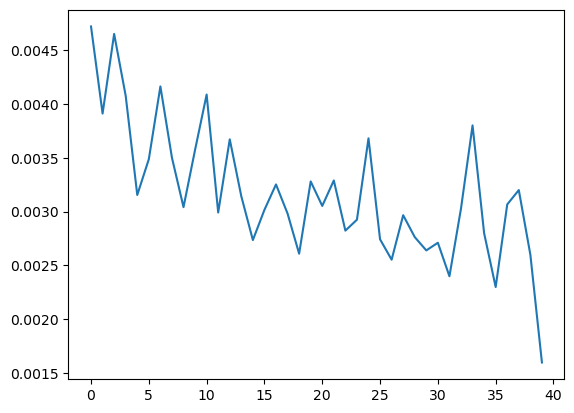

In [15]:
plt.plot(rewards)

# Optimizations

In [16]:
import cProfile

In [17]:
def stress_test():
    train_loop( custom_gym, 
        model, 
        games_per_checkpoint=1,
        checkpoints=1,
        optimization_passes = 1, 
        difficulty_rate= 2,
        seed=42
    )

In [18]:

cProfile.run('stress_test()', sort = 'time')

Training on thesis.


Training Progress: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

Finished training on thesis.
         4279384 function calls (4278382 primitive calls) in 4.847 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    12279    0.820    0.000    0.820    0.000 {method 'item' of 'torch._C.TensorBase' objects}
    18096    0.774    0.000    0.774    0.000 {method 'to' of 'torch._C.TensorBase' objects}
      514    0.696    0.001    0.714    0.001 sar_action_interpreter.py:32(get_action_mask)
     7936    0.382    0.000    0.382    0.000 {built-in method torch.tensor}
     3496    0.157    0.000    0.157    0.000 {built-in method torch.stack}
     3872    0.147    0.000    0.147    0.000 {built-in method torch.conv2d}
     3528    0.099    0.000    0.099    0.000 {built-in method torch._C._nn.linear}
        4    0.094    0.024    0.131    0.033 terrain_map.py:22(compute_gradient_map)
     3384    0.094    0.000    0.457    0.000 _lazy.py:994(_get_str)
     6604    0.075    0.000    0.075    0.00

# Visualization

In [19]:
from models.base import RenderWrapper

renderer = RenderWrapper(model=model)

In [20]:
renderer.render()